## Data Augmentation 

In [10]:
from keras.preprocessing.image import ImageDataGenerator
import os
from os.path import isfile, join
import pandas as pd
import numpy as np
from skimage.io import imread
from tqdm import tqdm

In [11]:
# First create a data generator
datagen = ImageDataGenerator(rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.15,
                            zoom_range=0.1,
                            channel_shift_range=10,
                            horizontal_flip=True)

In [3]:
# 2nd realize transformations on the images

baseball = ['img/train/baseball/' + f for f in os.listdir('img/train/baseball/') if isfile(join('img/train/baseball/', f))]
image_path = baseball[0]
image = np.expand_dims(imread(image_path), axis=0)


In [4]:
# Select destination for augmentated images

save_here = 'img/train/baseball/aug'

try:
    os.stat(save_here)
except:
    os.mkdir(save_here)

In [ ]:
# fit of the original image
datagen.fit(image)

In [5]:
# Augmentation for all images of baseball
i=0
for image_path in tqdm(baseball):
    image = np.expand_dims(imread(image_path), axis=0) 
    datagen.fit(image)
    for x, val in zip(datagen.flow(image,                     # image we choose
                              save_to_dir=save_here,          # the folder on we save the new image 
                              save_prefix='aug',               
                              save_format='png'), range(100)): # number of augmented images we want
        pass
    i+= 1
    if i == 64:
        break

 95%|█████████▌| 63/66 [05:10<00:14,  4.93s/it]


In [ ]:
i=0
cricket = ['img/train/cricket/' + f for f in os.listdir('img/train/cricket/') if isfile(join('img/train/cricket/', f))]
save_here = 'img/train/cricket/aug'
try:
    os.stat(save_here)
except:
    os.mkdir(save_here)
for image_path in tqdm(cricket):
    image = np.expand_dims(imread(image_path), axis=0) 
    datagen.fit(image)
    for x, val in zip(datagen.flow(image,                     # image we choose
                              save_to_dir=save_here,          # the folder on we save the new image 
                              save_prefix='aug',               
                              save_format='png'), range(100)): # number of augmented images we want
        pass
    i+= 1
    if i == 64:
        break

In [ ]:
i=0
football = ['img/train/football/' + f for f in os.listdir('img/train/football/') if isfile(join('img/train/football/', f))]
save_here = 'img/train/football/aug'
try:
    os.stat(save_here)
except:
    os.mkdir(save_here)
for image_path in tqdm(football):
    image = np.expand_dims(imread(image_path), axis=0) 
    datagen.fit(image)
    for x, val in zip(datagen.flow(image,                     # image we choose
                              save_to_dir=save_here,          # the folder on we save the new image 
                              save_prefix='aug',               
                              save_format='png'), range(100)): # number of augmented images we want
        pass
    i+= 1
    if i == 64:
        break

In [12]:
targets = ['baseball', 'cricket', 'football']

In [13]:
def augment_data(datagen, target: str)->None:
    '''
        This function receives a data generator and target and returns
        a number of copies of the same image with different transformations,
        to increment the number of images for train our model
        
        Parameters:
            datagen: Object generator with the features to transform the image
            target: str
    
        Returns:
            A message of work is done
    '''
    
    # first create a list of the files on the target folder
    target_lst = [f'img/train/{target}/' + f for f in os.listdir(f'img/train/{target}/') if isfile(join(f'img/train/{target}/', f))]
    # path for save the augmentated data
    save_here = f'img/train/{target}/aug'
    try:
        os.stat(save_here) # if folder exits save on it
    except:
        os.mkdir(save_here) # if not, create it and save on it
    for i in tqdm(range(64)):
        # transformation the image
        image = np.expand_dims(imread(target_lst[i]), axis=0) 
        datagen.fit(image)
        # makes the augmetation
        for x, val in zip(datagen.flow(image,                     # image we choose
                                  save_to_dir=save_here,          # the folder on we save the new image 
                                  save_prefix='aug',               
                                  save_format='png'), range(100)): # number of augmented images we want
            pass
    return 'Augmentation Finished'

In [14]:
for target in targets:
    augment_data(datagen, target)

100%|██████████| 64/64 [04:13<00:00,  3.97s/it]


## Prepare data

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
import cv2

In [16]:
X = []
Y = []

for file in tqdm(os.listdir('img/train/baseball/aug/')):
    image = imread('img/train/baseball/aug/'+file)
    smallimage = cv2.resize(image,(64,64))
    X.append(smallimage)
    Y.append(0)

for file in tqdm(os.listdir('img/train/cricket/aug/')):
    image = imread('img/train/cricket/aug/'+file)
    smallimage = cv2.resize(image,(64,64))
    X.append(smallimage)
    Y.append(1)

for file in tqdm(os.listdir('img/train/football/aug/')):
    image = imread('img/train/football/aug/'+file)
    smallimage = cv2.resize(image,(64,64))
    X.append(smallimage)
    Y.append(2)

100%|██████████| 4793/4793 [00:25<00:00, 189.68it/s]


In [17]:
X_128 = []
Y_128 = []

for file in tqdm(os.listdir('img/train/baseball/aug/')):
    image = imread('img/train/baseball/aug/'+file)
    smallimage = cv2.resize(image,(128,128))
    X_128.append(smallimage)
    Y_128.append(0)

for file in tqdm(os.listdir('img/train/cricket/aug/')):
    image = imread('img/train/cricket/aug/'+file)
    smallimage = cv2.resize(image,(128,128))
    X_128.append(smallimage)
    Y_128.append(1)

for file in tqdm(os.listdir('img/train/football/aug/')):
    image = imread('img/train/football/aug/'+file)
    smallimage = cv2.resize(image,(128,128))
    X_128.append(smallimage)
    Y_128.append(2)

100%|██████████| 4793/4793 [00:17<00:00, 267.32it/s]


In [18]:
X,Y = np.array(X), np.array(Y)
X_128,Y_128 = np.array(X_128), np.array(Y_128)

In [19]:
X = X/255.0 # normalize X
X_128 = X_128/255.0

In [20]:
from sklearn.utils import shuffle

X,Y = shuffle(X,Y, random_state=42)

X_128,Y_128 = shuffle(X_128,Y_128, random_state=42)

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = .2, random_state=42, stratify=Y)

print(X_train.shape); print(X_test.shape)

(11474, 64, 64, 3)
(2869, 64, 64, 3)


In [22]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print(np.unique(y_train,return_counts=True),'values of each class')

X_train shape: (11474, 64, 64, 3)
11474 train samples
2869 test samples
(array([0, 1, 2]), array([3814, 3826, 3834], dtype=int64)) values of each class


### Convolutional Network

In [23]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Activation
import numpy as np
from keras.layers.core import Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.core import Flatten
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

In [24]:
Y_train = np_utils.to_categorical(y_train,3)
Y_test = np_utils.to_categorical(y_test,3)

### Create metric functions for model evaluation

In [25]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [26]:
X_train.shape, Y_train.shape

((11474, 64, 64, 3), (11474, 3))

## Create a convolutional Network

Epoch 1/20
90/90 - 43s - loss: 1.0391 - accuracy: 0.4967 - f1_m: 0.3267 - recall_m: 0.2518 - precision_m: 0.5441 - 43s/epoch - 475ms/step
Epoch 2/20
90/90 - 41s - loss: 0.6483 - accuracy: 0.7293 - f1_m: 0.6988 - recall_m: 0.6298 - precision_m: 0.7890 - 41s/epoch - 450ms/step
Epoch 3/20
90/90 - 42s - loss: 0.3410 - accuracy: 0.8660 - f1_m: 0.8625 - recall_m: 0.8375 - precision_m: 0.8898 - 42s/epoch - 468ms/step
Epoch 4/20
90/90 - 42s - loss: 0.1525 - accuracy: 0.9467 - f1_m: 0.9473 - recall_m: 0.9406 - precision_m: 0.9540 - 42s/epoch - 466ms/step
Epoch 5/20
90/90 - 43s - loss: 0.0821 - accuracy: 0.9746 - f1_m: 0.9749 - recall_m: 0.9727 - precision_m: 0.9771 - 43s/epoch - 475ms/step
Epoch 6/20
90/90 - 45s - loss: 0.0563 - accuracy: 0.9814 - f1_m: 0.9813 - recall_m: 0.9800 - precision_m: 0.9826 - 45s/epoch - 502ms/step
Epoch 7/20
90/90 - 49s - loss: 0.0383 - accuracy: 0.9895 - f1_m: 0.9896 - recall_m: 0.9891 - precision_m: 0.9900 - 49s/epoch - 540ms/step
Epoch 8/20
90/90 - 47s - loss: 0.0

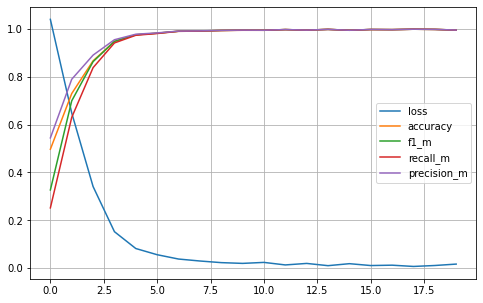

In [27]:
img_rows = 64
img_cols = 64
kernel_size = 4 # Size of the kernel for the convolution layers
pool_size = 2 # Size of the pooling region for the pooling layers

model = Sequential()

model.add(Convolution2D(32, # Number convolution channels to generate
                        (kernel_size, kernel_size), # Size of convolution kernels
                        padding='valid', # Strategy to deal with borders
                        input_shape=(img_rows, img_cols, 3))) # Size = image rows x image columns x channels
model.add(Activation('relu'))
model.add(Convolution2D(32, # Number convolution channels to generate
                        (kernel_size, kernel_size), # Size of convolution kernels
                        padding='valid', # Strategy to deal with borders
                        input_shape=(img_rows, img_cols, 3))) # Size = image rows x image columns x channels
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy", f1_m, recall_m, precision_m])
history_3 = model.fit(
    X_train, # Training data
    Y_train, # Labels of training data
    batch_size=128, # Batch size for the optimizer algorithm
    epochs=20, # Number of epochs to run the optimizer algorithm
    verbose=1 # Level of verbosity of the log messages
)
score = model.evaluate(X_test, Y_test)
print("Test loss", score[0])
print("Test accuracy", score[1])

pd.DataFrame(history_3.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

## Prepare data test to predict

In [28]:
test = []

for file in os.listdir('img/test/'):
    image = imread('img/test/'+file)
    smallimage = cv2.resize(image,(64,64))
    test.append(smallimage)

test = np.array(test)/255.0

In [29]:
preds = []
for i in range(len(test)):
    pred = model.predict(np.expand_dims(test[i], axis=0))
    #print(pred)
    if pred[0][0]>pred[0][1] and pred[0][0]>pred[0][2]:
        preds.append(0)
    elif pred[0][1]>pred[0][0] and pred[0][1]>pred[0][2]:
        preds.append(1)
    else:
        preds.append(2)

1/1 [==============================] - 0s 15ms/step


[1,
 0,
 2,
 2,
 1,
 1,
 0,
 2,
 2,
 0,
 2,
 0,
 1,
 0,
 2,
 1,
 1,
 2,
 0,
 0,
 0,
 1,
 0,
 2,
 1,
 0,
 1,
 2,
 0,
 0,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 0,
 0,
 0,
 1]

C:\Users\botic\AppData\Local\Temp\ipykernel_54208\3168350087.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(30,20))


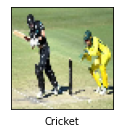

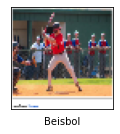

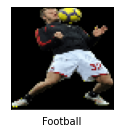

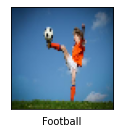

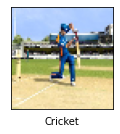

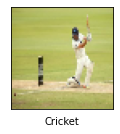

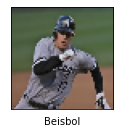

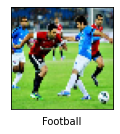

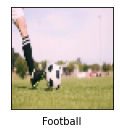

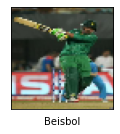

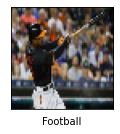

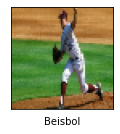

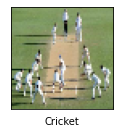

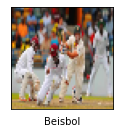

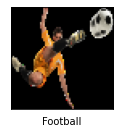

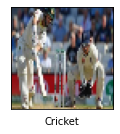

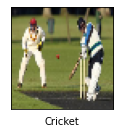

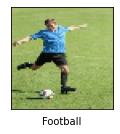

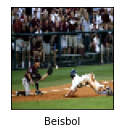

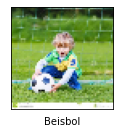

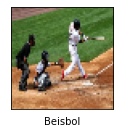

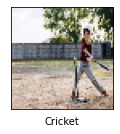

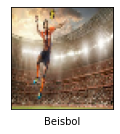

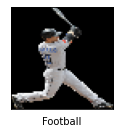

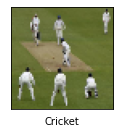

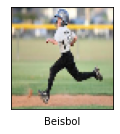

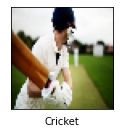

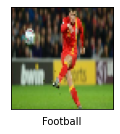

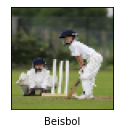

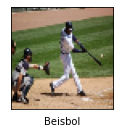

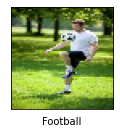

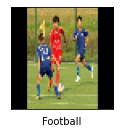

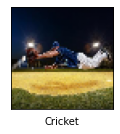

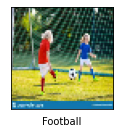

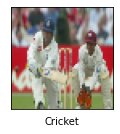

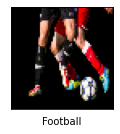

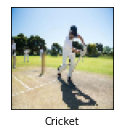

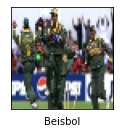

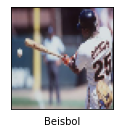

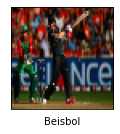

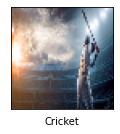

In [30]:
for i in range(len(test)):
    plt.figure(figsize=(30,20))
    plt.subplot(9,5,i+1)
    plt.xticks([])
    plt.yticks([])
    if preds[i] == 0:
        plt.xlabel('Beisbol')
        plt.imshow(test[i])
    elif preds[i] == 1:
        plt.xlabel('Cricket')
        plt.imshow(test[i])
    else:
        plt.xlabel('Football')
        plt.imshow(test[i])
plt.show()

## Convolutional network with 128 x 128 pixels images

In [56]:
X_train_128, X_test_128, y_train_128, y_test_128 = train_test_split(X_128,Y_128, test_size = .2, random_state=42, stratify=Y_128)

print(X_train_128.shape); print(X_test_128.shape)

(11474, 128, 128, 3)
(2869, 128, 128, 3)


In [57]:
Y_train_128 = np_utils.to_categorical(y_train,3)
Y_test_128 = np_utils.to_categorical(y_test,3)

Epoch 1/20
90/90 [==============================] - 221s 2s/step - loss: 1.1266 - accuracy: 0.5096 - f1_m: 0.3398 - recall_m: 0.2540 - precision_m: 0.6758
Epoch 2/20
90/90 [==============================] - 211s 2s/step - loss: 0.5989 - accuracy: 0.7536 - f1_m: 0.7259 - recall_m: 0.6561 - precision_m: 0.8170
Epoch 3/20
90/90 [==============================] - 220s 2s/step - loss: 0.2463 - accuracy: 0.9108 - f1_m: 0.9095 - recall_m: 0.8937 - precision_m: 0.9261
Epoch 4/20
90/90 [==============================] - 213s 2s/step - loss: 0.0989 - accuracy: 0.9695 - f1_m: 0.9686 - recall_m: 0.9651 - precision_m: 0.9722
Epoch 5/20
90/90 [==============================] - 219s 2s/step - loss: 0.0657 - accuracy: 0.9800 - f1_m: 0.9797 - recall_m: 0.9784 - precision_m: 0.9810
Epoch 6/20
90/90 [==============================] - 218s 2s/step - loss: 0.0304 - accuracy: 0.9916 - f1_m: 0.9916 - recall_m: 0.9912 - precision_m: 0.9919
Epoch 7/20
90/90 [==============================] - 215s 2s/step - los

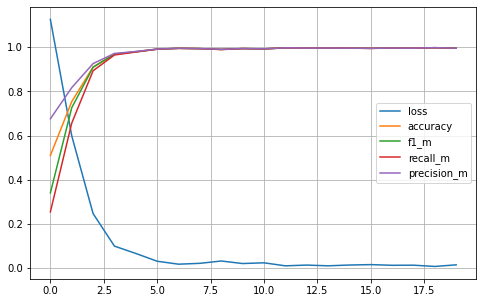

In [60]:
img_rows = 128
img_cols = 128
kernel_size = 4 # Size of the kernel for the convolution layers
pool_size = 2 # Size of the pooling region for the pooling layers

model = Sequential()

model.add(Convolution2D(32, # Number convolution channels to generate
                        (kernel_size, kernel_size), # Size of convolution kernels
                        padding='valid', # Strategy to deal with borders
                        input_shape=(img_rows, img_cols, 3))) # Size = image rows x image columns x channels
model.add(Activation('relu'))
model.add(Convolution2D(32, # Number convolution channels to generate
                        (kernel_size, kernel_size), # Size of convolution kernels
                        padding='valid', # Strategy to deal with borders
                        input_shape=(img_rows, img_cols, 3))) # Size = image rows x image columns x channels
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy", f1_m, recall_m, precision_m])
history_3 = model.fit(
    X_train_128, # Training data
    Y_train_128, # Labels of training data
    batch_size=128, # Batch size for the optimizer algorithm
    epochs=20, # Number of epochs to run the optimizer algorithm
    verbose=1 # Level of verbosity of the log messages
)
score = model.evaluate(X_test_128, Y_test_128)
print("Test loss", score[0])
print("Test accuracy", score[1])

pd.DataFrame(history_3.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

In [61]:
test_128 = []

for file in os.listdir('img/test/'):
    image = imread('img/test/'+file)
    smallimage = cv2.resize(image,(128,128))
    test_128.append(smallimage)

test_128 = np.array(test_128)/255.0

In [62]:
preds_128 = []
preds_128_arr = []
for i in range(len(test_128)):
    pred_128 = model.predict(np.expand_dims(test[i], axis=0))
    preds_128_arr.append(pred_128)
    #print(pred)
    if pred_128[0][0]>pred_128[0][1] and pred_128[0][0]>pred_128[0][2]:
        preds_128.append(0)
    elif pred_128[0][1]>pred_128[0][0] and pred_128[0][1]>pred_128[0][2]:
        preds_128.append(1)
    else:
        preds_128.append(2)


1/1 [==============================] - 0s 33ms/step


In [66]:
preds_128

[1,
 0,
 2,
 2,
 1,
 1,
 0,
 2,
 2,
 1,
 2,
 0,
 1,
 0,
 2,
 1,
 1,
 2,
 0,
 1,
 0,
 0,
 0,
 2,
 1,
 2,
 2,
 2,
 1,
 0,
 2,
 2,
 0,
 0,
 1,
 2,
 1,
 2,
 1,
 2,
 2]

## Transfer Learning

In [32]:
from keras.utils import np_utils
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import datasets, layers, models
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [33]:
from tensorflow.keras.applications.vgg16 import VGG16
base_model = VGG16(input_shape=(64,64,3),
                  include_top = False,
                   weights = 'imagenet'
                  )

In [34]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [35]:
for layer in base_model.layers:
    layer.trainable = False

In [36]:
## train de last layer of or base model with our data

x = layers.Flatten()(base_model.output)

x = layers.Dense(512, activation='relu')(x)

x = layers.Dense(3, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['acc', f1_m, recall_m, precision_m])

In [37]:
vgghist = model.fit(X_train, Y_train,
                    batch_size=64,
                   epochs = 15)

pd.DataFrame(vgghist.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

Epoch 1/20
180/180 [==============================] - 54s 295ms/step - loss: 0.2939 - acc: 0.8977 - f1_m: 0.8476 - recall_m: 0.9470 - precision_m: 0.7707
Epoch 2/20
180/180 [==============================] - 56s 312ms/step - loss: 0.0341 - acc: 0.9941 - f1_m: 0.9524 - recall_m: 0.9960 - precision_m: 0.9129
Epoch 3/20
180/180 [==============================] - 56s 311ms/step - loss: 0.0116 - acc: 0.9990 - f1_m: 0.9649 - recall_m: 0.9993 - precision_m: 0.9333
Epoch 4/20
180/180 [==============================] - 54s 300ms/step - loss: 0.0044 - acc: 1.0000 - f1_m: 0.9737 - recall_m: 0.9999 - precision_m: 0.9492
Epoch 5/20
180/180 [==============================] - 55s 305ms/step - loss: 0.0020 - acc: 1.0000 - f1_m: 0.9789 - recall_m: 1.0000 - precision_m: 0.9590
Epoch 6/20
180/180 [==============================] - 56s 312ms/step - loss: 0.0013 - acc: 1.0000 - f1_m: 0.9796 - recall_m: 1.0000 - precision_m: 0.9604
Epoch 7/20
180/180 [==============================] - 56s 311ms/step - loss:

### First model transfer learning predictions

In [38]:
tl1_preds = []
tl1_preds_arr = []
for i in range(len(test)):
    tlf1_pred = model.predict(np.expand_dims(test[i], axis=0))
    tl1_preds_arr.append(tlf1_pred)
    #print(pred)
    if tlf1_pred[0][0]>tlf1_pred[0][1] and tlf1_pred[0][0]>tlf1_pred[0][2]:
        tl1_preds.append(0)
    elif tlf1_pred[0][1]>tlf1_pred[0][0] and tlf1_pred[0][1]>tlf1_pred[0][2]:
        tl1_preds.append(1)
    else:
        tl1_preds.append(2)
tl1_preds

1/1 [==============================] - 0s 24ms/step


[2,
 0,
 2,
 2,
 1,
 0,
 2,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 0,
 1,
 0,
 0,
 0,
 2,
 1,
 2,
 2,
 1,
 1,
 0,
 2,
 0,
 1,
 2,
 1,
 2,
 0,
 1,
 0,
 2,
 2]

C:\Users\botic\AppData\Local\Temp\ipykernel_54208\4222965803.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(30,20))


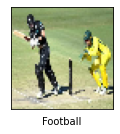

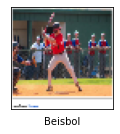

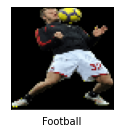

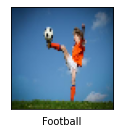

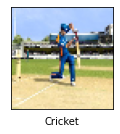

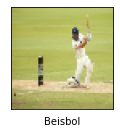

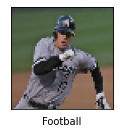

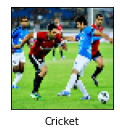

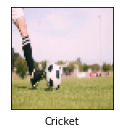

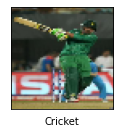

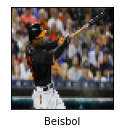

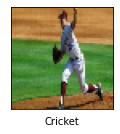

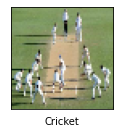

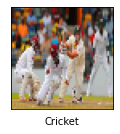

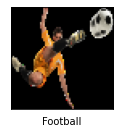

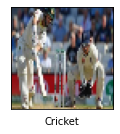

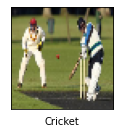

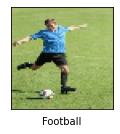

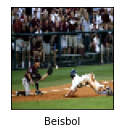

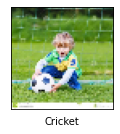

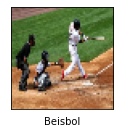

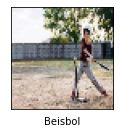

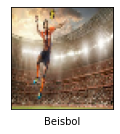

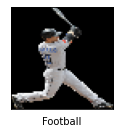

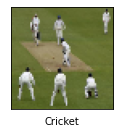

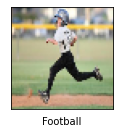

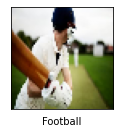

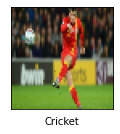

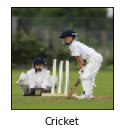

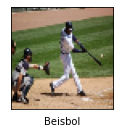

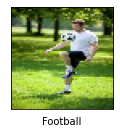

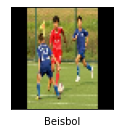

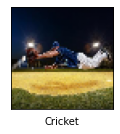

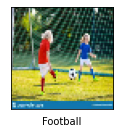

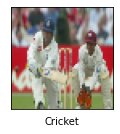

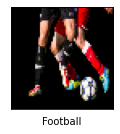

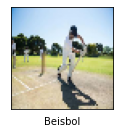

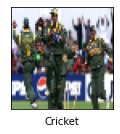

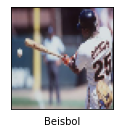

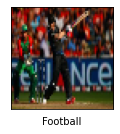

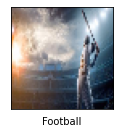

In [39]:
for i in range(len(test)):
    plt.figure(figsize=(30,20))
    plt.subplot(9,5,i+1)
    plt.xticks([])
    plt.yticks([])
    if tl1_preds[i] == 0:
        plt.xlabel('Beisbol')
        plt.imshow(test[i])
    elif tl1_preds[i] == 1:
        plt.xlabel('Cricket')
        plt.imshow(test[i])
    else:
        plt.xlabel('Football')
        plt.imshow(test[i])
plt.show()

## Test for samples of 128 x 128


In [42]:
base_model = VGG16(input_shape=(128,128,3),
                  include_top = False,
                   weights = 'imagenet'
                  )

for layer in base_model.layers:
    layer.trainable = False

In [43]:
x = layers.Flatten()(base_model.output)

x = layers.Dense(512, activation='relu')(x)

x = layers.Dense(3, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['acc', f1_m, recall_m, precision_m])

vgghist = model.fit(X_train_128, Y_train_128,
                    batch_size=64,
                   epochs = 20)
pd.DataFrame(vgghist.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

Epoch 1/12
180/180 [==============================] - 204s 1s/step - loss: 0.3280 - acc: 0.9119 - f1_m: 0.7565 - recall_m: 0.9687 - precision_m: 0.6268
Epoch 2/12
180/180 [==============================] - 196s 1s/step - loss: 0.0109 - acc: 0.9994 - f1_m: 0.8910 - recall_m: 1.0000 - precision_m: 0.8042
Epoch 3/12
180/180 [==============================] - 197s 1s/step - loss: 0.0029 - acc: 1.0000 - f1_m: 0.9273 - recall_m: 1.0000 - precision_m: 0.8652
Epoch 4/12
180/180 [==============================] - 206s 1s/step - loss: 0.0014 - acc: 1.0000 - f1_m: 0.9385 - recall_m: 1.0000 - precision_m: 0.8849
Epoch 5/12
180/180 [==============================] - 194s 1s/step - loss: 7.6012e-04 - acc: 1.0000 - f1_m: 0.9502 - recall_m: 1.0000 - precision_m: 0.9055
Epoch 6/12
180/180 [==============================] - 193s 1s/step - loss: 5.0056e-04 - acc: 1.0000 - f1_m: 0.9571 - recall_m: 1.0000 - precision_m: 0.9181
Epoch 7/12
180/180 [==============================] - 195s 1s/step - loss: 3.574

## Make predictions

In [45]:
preds_tl_128 = []
preds_tl_128_arr = []
for i in range(len(test_128)):
    pred_128_tf = model.predict(np.expand_dims(test_128[i], axis=0))
    preds_tl_128_arr.append(pred_128_tf)
    #print(pred)
    if pred_128_tf[0][0]>pred_128_tf[0][1] and pred_128_tf[0][0]>pred_128_tf[0][2]:
        preds_tl_128.append(0)
    elif pred_128_tf[0][1]>pred_128_tf[0][0] and pred_128_tf[0][1]>pred_pred_128_tf128[0][2]:
        preds_tl_128.append(1)
    else:
        preds_tl_128.append(2)

1/1 [==============================] - 0s 40ms/step


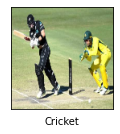

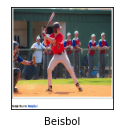

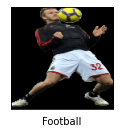

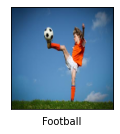

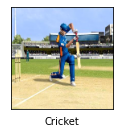

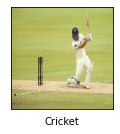

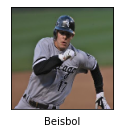

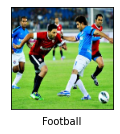

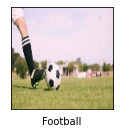

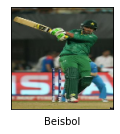

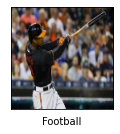

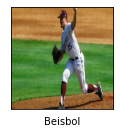

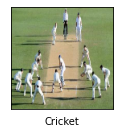

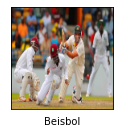

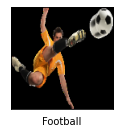

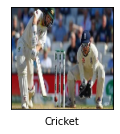

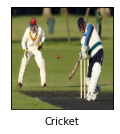

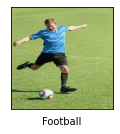

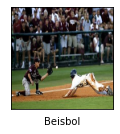

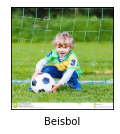

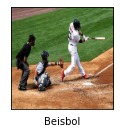

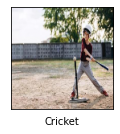

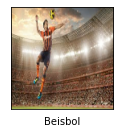

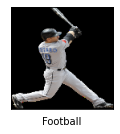

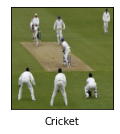

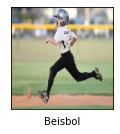

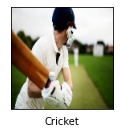

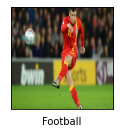

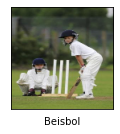

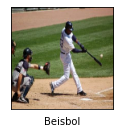

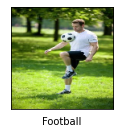

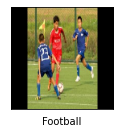

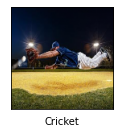

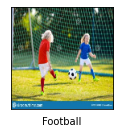

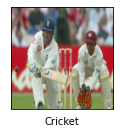

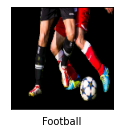

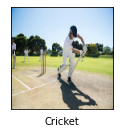

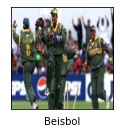

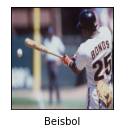

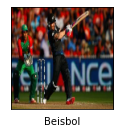

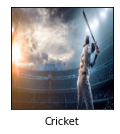

In [51]:

for i in range(len(test_128)):
    plt.figure(figsize=(30,20))
    plt.subplot(9,5,i+1)
    plt.xticks([])
    plt.yticks([])
    if preds_tl_128[i] == 0:
        plt.xlabel('Beisbol')
        plt.imshow(test_128[i])
    elif preds_tl_128[i] == 1:
        plt.xlabel('Cricket')
        plt.imshow(test_128[i])
    else:
        plt.xlabel('Football')
        plt.imshow(test_128[i])
plt.show()

In [47]:
true = [1,0,2,2,1,1,0,2,2,1,0,0,1,1,2,1,1,2,0,2,0,0,2,0,1,0,1,2,1,0,2,2,0,2,1,2,1,1,0,1,0]

In [67]:
preds_conv = 0
preds_conv_128 = 0
pred_res = 0
pred_128_res = 0
for i in range(len(preds)):
    if preds[i] == true[i]:
        preds_conv += 1
    if preds_128[i] == true[i]:
        preds_conv_128 += 1
    '''if tl1_preds[i] == true[i]:
        pred_res += 1
    if preds_tl_128[i] == true[i]:
        pred_128_res += 1'''

print('Preds convolutional network: ', preds_conv,'\nPreds for conv 128x128: ', preds_conv_128,
      '\nPreds for tfl1 64x64: ', pred_res, '\nPreds for  tfl2128x128: ', pred_128_res
     )

Preds convolutional network:  29 
Preds for conv 128x128:  29
